In [20]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/work/Data Science/sheffield-bats


In [21]:
import geopandas as gpd
import pandas as pd
import elapid as ela

In [22]:
from pipelines.load_boundary import load_south_yorkshire
south_yorkshire = load_south_yorkshire()
south_yorkshire


,FID,CTYUA23CD,CTYUA23NM,CTYUA23NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
78,79,E08000016,Barnsley,,429979,403327,-1.54925,53.5258,52537552-62db-4c88-b3ea-2f96ca6a22f6,"POLYGON ((436681.403 413010.696, 436690.200 41..."
79,80,E08000017,Doncaster,,459167,403735,-1.10894,53.5270,7c6c566b-c170-481a-8003-2b49623e891a,"POLYGON ((466803.802 418480.101, 466797.297 41..."
80,81,E08000018,Rotherham,,447542,388980,-1.28651,53.3955,75e98107-576c-483c-bd0c-8614bb114af7,"POLYGON ((442015.603 402228.603, 442078.397 40..."
81,82,E08000019,Sheffield,,430511,389736,-1.54254,53.4036,48429bcc-adff-40c1-b837-1b9f7d683615,"POLYGON ((420032.497 400718.505, 420093.197 40..."


<Axes: >

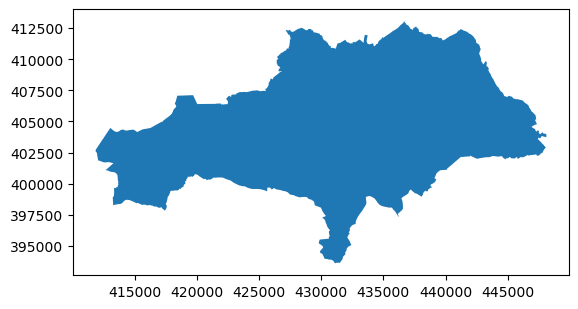

In [23]:
barnsley = south_yorkshire[south_yorkshire.CTYUA23NM == 'Barnsley']
barnsley.plot()

In [24]:
bats = gpd.read_parquet('data/processed/sybg-bats.parquet')
bats = bats[bats.accuracy <= 100]
bats = bats.to_crs(27700)

bats.head()

,grid_reference,species_raw,activity_type,source_data,date,latin_name,common_name,genus,x,y,accuracy,geometry,grid_square_geom
0,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",2010-05-17 00:00:00,Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,100.0,POINT (411550.000 508450.000),"POLYGON ((411600.000 508400.000, 411600.000 50..."
1,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",2014-07-03 00:00:00,Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,10.0,POINT (414645.000 500215.000),"POLYGON ((414650.000 500210.000, 414650.000 50..."
2,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",2013-11-28 00:00:00,Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,10.0,POINT (420295.000 511065.000),"POLYGON ((420300.000 511060.000, 420300.000 51..."
3,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",2010-08-31 00:00:00,Unknown,Unidentified Bat,Unknown,417050.0,501450.0,100.0,POINT (417050.000 501450.000),"POLYGON ((417100.000 501400.000, 417100.000 50..."
4,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",2009-05-20 00:00:00,Unknown,Unidentified Bat,Unknown,418550.0,511650.0,100.0,POINT (418550.000 511650.000),"POLYGON ((418600.000 511600.000, 418600.000 51..."


In [25]:
# get foraging pipistrelles

foraging = bats[(bats.latin_name == 'Pipistrellus pipistrellus') & (bats.activity_type == 'Foraging')]
foraging = foraging[foraging.intersects(barnsley.unary_union)]

# Sample Weighting

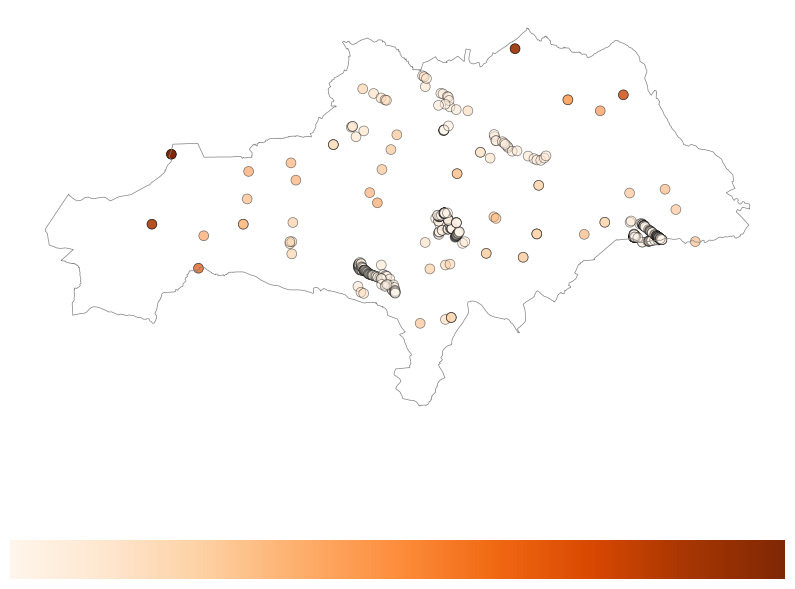

In [26]:
foraging["sample_weight"] = ela.distance_weights(foraging.geometry, n_neighbors=5)
# normalise it 
foraging["sample_weight"] = foraging["sample_weight"] / foraging["sample_weight"].max()
foraging = foraging[foraging.geometry.is_valid]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    1, 1, figsize=(10, 10)
)
barnsley.boundary.plot(ax=ax, color='grey', linewidth=0.5)
# plot the foraging bats
# plot the points with a dark grey outline and an orange fill
# make the fill darker where the sample has a higher weight

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('Oranges')
sm = ScalarMappable(norm=norm, cmap=cmap)
foraging.plot(
    ax=ax, 
    color=sm.to_rgba(foraging.sample_weight),
    linewidth=0.5, 
    edgecolor='black',
    markersize=50,
    alpha=foraging.sample_weight.clip(0.5, 1)

    )

# add a colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Sample weight')


# drop the axis
ax.axis('off')
cbar.ax.axis('off')

plt.show()

# Background Points


In [27]:
bg_points = gpd.read_parquet("data/processed/background-points.parquet")
bg_points = bg_points.to_crs(27700)

In [28]:
import rioxarray as rxr
density_array = rxr.open_rasterio('data/processed/bat_density.tif')
density_array

<xarray.DataArray (band: 1, y: 562, x: 791)> Size: 4MB
[444542 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 6kB 4.039e+05 4.04e+05 ... 4.829e+05 4.83e+05
  * y            (y) float64 4kB 3.705e+05 3.706e+05 ... 4.266e+05 4.267e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [29]:
# clip both to barnsley
density_array = density_array.rio.clip(barnsley.geometry)
density_array = density_array / density_array.max()


bg_points = bg_points[bg_points.intersects(barnsley.unary_union)]


In [30]:
# get quartiles

density_array.min(), density_array.max()

(<xarray.DataArray ()> Size: 8B
 array(0.1)
 Coordinates:
     spatial_ref  int64 8B 0,
 <xarray.DataArray ()> Size: 8B
 array(1.)
 Coordinates:
     spatial_ref  int64 8B 0)

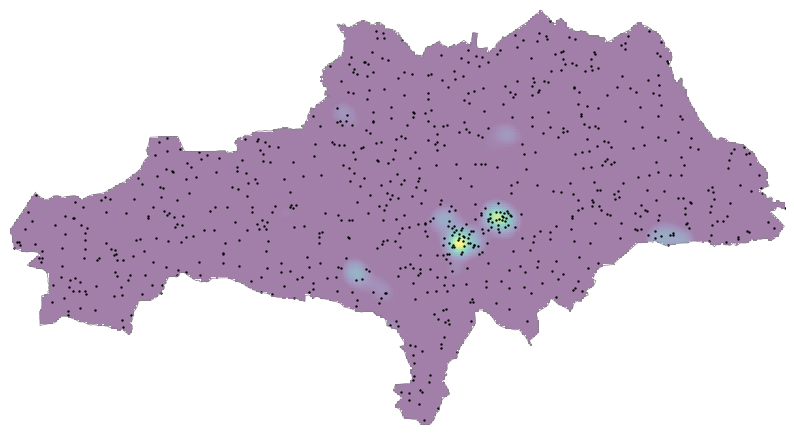

In [31]:
import numpy as np
# normalise the density array
#density_array = density_array.where(density_array > 0.1, np.nan)

# plot the density array
fig, ax = plt.subplots(
    1, 1, figsize=(10, 10)
)
barnsley.boundary.plot(ax=ax, color='grey', linewidth=0.5)
density_array.plot(ax=ax, cmap='viridis', alpha=0.5, add_colorbar=False)
bg_points.plot(ax=ax, color='black', markersize=0.5)
ax.axis('off')
# remove title
ax.set_title('')
plt.show()

In [32]:
from sdm.features import load_evs
from pathlib import Path
ev_folder = Path("data/evs/")
evs = load_evs(ev_folder)

keep_evs = [
    "climate_stats_wind_ann_avg",
    "dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation",
    "climate_stats_temp_ann_avg",
    "climate_stats_prec_ann_avg",
    "bioclim_bioclim_15",
    "os-distance-to-feature_distance_to_buildings",
    "terrain-stats_slope",
    "terrain-stats_twi",
    "bioclim_bioclim_9",
    "ceh-land-cover-100m_Arable",
    "ceh-land-cover-100m_Improved grassland",
    "veg-height-100m_veg_height_max",
    "os-feature-cover-100m_water",
    "terrain-stats_aspect_northness_slope",
    "terrain-stats_aspect_eastness_slope",
    "terrain-stats_tpi",
    "ceh-land-cover-100m_Wetland",
    "os-feature-cover-100m_major_roads",
    "ceh-land-cover-100m_Upland Heathland",
    "ceh-land-cover-100m_Suburban",
    "ceh-land-cover-100m_Grassland",
    "os-distance-to-feature_distance_to_major_roads",
    "ceh-land-cover-100m_Urban",
    "os-distance-to-feature_distance_to_water",
    "ceh-land-cover-100m_Coniferous woodland",
]

#evs = evs[keep_evs]
evs

<xarray.Dataset> Size: 262MB
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 6kB 4.039e+05...
  * y                                               (y) float64 5kB 4.268e+05...
    spatial_ref                                     int64 8B 0
Data variables: (12/97)
    climate_stats_temp_ann_var                      (y, x) float64 4MB ...
    climate_stats_temp_ann_avg                      (y, x) float64 4MB ...
    climate_stats_temp_mat_avg                      (y, x) float64 4MB ...
    climate_stats_prec_ann_var                      (y, x) float64 4MB ...
    climate_stats_prec_ann_avg                      (y, x) float64 4MB ...
    climate_stats_wind_ann_var                      (y, x) float64 4MB ...
    ...                                              ...
    ceh-land-cover-100m_Upland Heathland            (y, x) float64 4MB ...
    ceh-land-cover-100m_Wetland                     (y, x) float64 4MB ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 2MB ...
    veg-height-100m_veg_height_mean                 (y, x) float32 2MB ...
    veg-height-100m_veg_height_std                  (y, x) float32 2MB ...
    veg-height-100m_veg_height_max                  (y, x) float32 2MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

In [33]:
evs = evs.rio.clip(south_yorkshire.geometry)

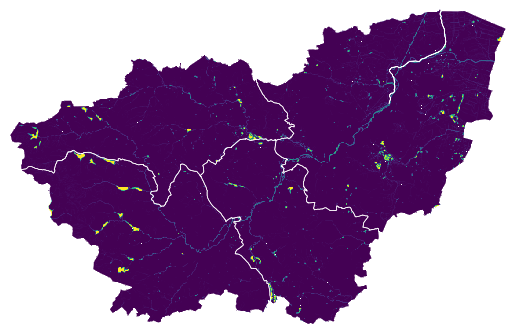

In [34]:
import xarray as xr
def plot_variable(dataset:xr.Dataset, variable:str, cmap:str='viridis', vmin=None, vmax=None):
    fig, ax = plt.subplots(
        1, 1
    )
    band = dataset[variable]
    if vmin is None:
        vmin = band.min()
    if vmax is None:
        vmax = band.max()
    mask = band.isnull()
    band = band.where(band > vmin, vmin)
    band = band.where(band < vmax, vmax)
    band = band.where(~mask, np.nan)
    band.plot(ax=ax, cmap=cmap, add_colorbar=False)
    south_yorkshire.boundary.plot(ax=ax, color='white', linewidth=0.5)
    ax.axis('off')
    ax.set_title("")
    plt.show()

plot_variable(evs, "os-feature-cover-100m_water", "viridis")

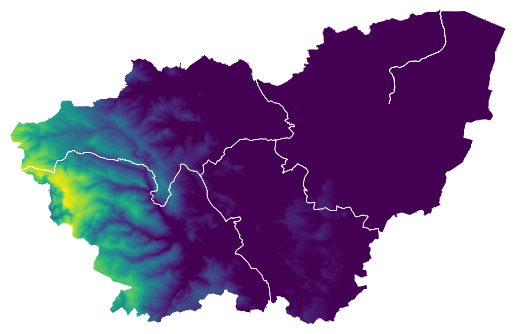

In [35]:
plot_variable(evs, "dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation", "viridis", vmin = 100)

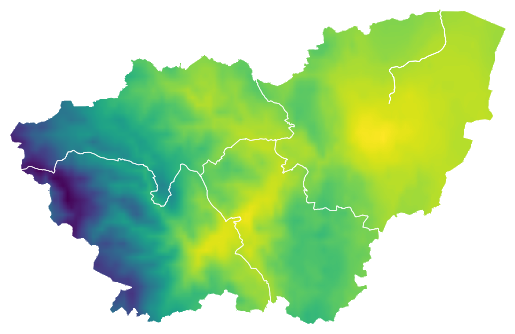

In [45]:
plot_variable(evs, "climate_stats_temp_ann_avg", "viridis", )

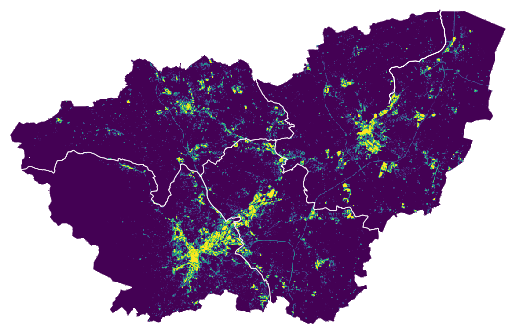

In [37]:
plot_variable(evs, "ceh-land-cover-100m_Urban", "viridis")

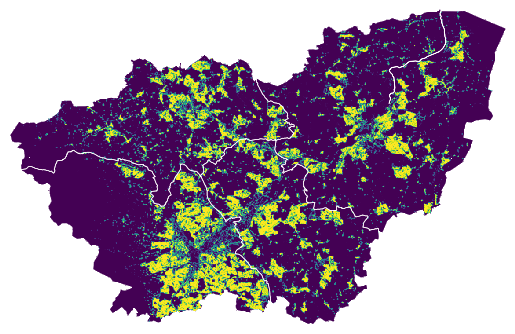

In [38]:
plot_variable(evs, "ceh-land-cover-100m_Suburban", "viridis")

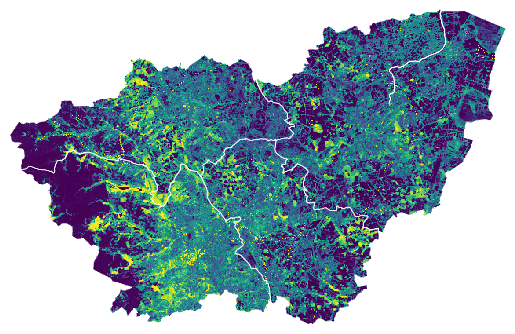

In [39]:
plot_variable(evs, "veg-height-100m_veg_height_max", "viridis", vmin=0, vmax=30)

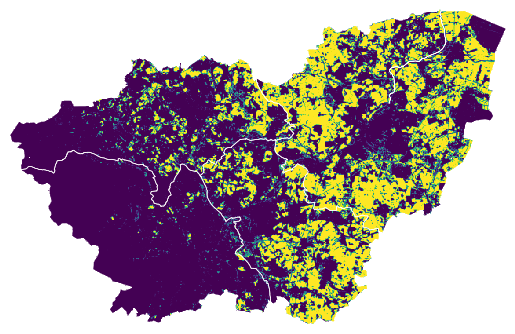

In [57]:
plot_variable(evs, "ceh-land-cover-100m_Arable", "viridis")

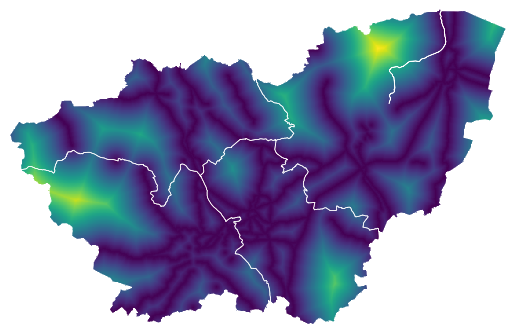

In [60]:
plot_variable(evs, "os-distance-to-feature_distance_to_major_roads", "viridis")

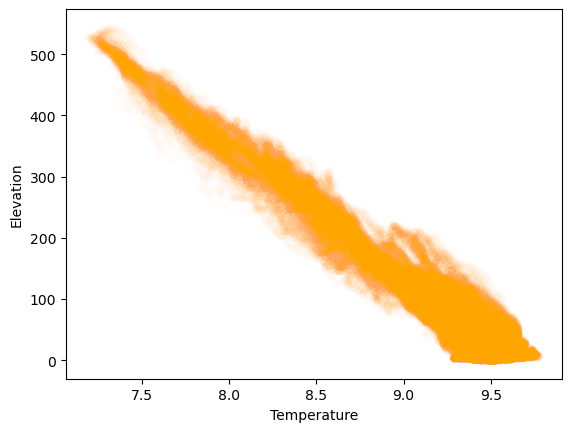

In [50]:
ev_df = evs.to_dataframe()

variables = ["climate_stats_temp_ann_avg" , "dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation"]
ax = ev_df.plot.scatter(x="climate_stats_temp_ann_avg", y="dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation", alpha=0.01, color='orange')
# add a linear regression line
import numpy as np
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(ev_df["climate_stats_temp_ann_avg"], ev_df["dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation"])
x = np.linspace(ev_df["climate_stats_temp_ann_avg"].min(), ev_df["climate_stats_temp_ann_avg"].max(), 100)
y = slope * x + intercept

ax.plot(x, y, color='black')

# set x label
ax.set_xlabel("Temperature")
# set y label
ax.set_ylabel("Elevation")
plt.show()
